In [1]:
# Env
import os
from dotenv import load_dotenv
if not load_dotenv() or 'HOPSWORKS_API_KEY' not in os.environ:
    print("Please provide a .env file add HOPSWORKS_API_KEY to it.")
    exit(1)

# No warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

# Imports
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
import hopsworks
import pandas as pd
import numpy as np
import math

# Heavy operation cache
from IPython.display import Image
from pathlib import Path
dir_plot_saves = "./plots"
# - Plots
Path(dir_plot_saves).mkdir(parents=True, exist_ok=True)
# Plot cache
def plot_or_cache(plotting_function, plot_name):
    plot_destination = f"{dir_plot_saves}/{plot_name}.png"
    if os.path.isfile(plot_destination):
        display(Image(filename=plot_destination))
    else:
        plotting_function()
        plt.savefig(plot_destination)
        plt.show()

# My help commands
from wine_training_help import evaluate_pca, train_evaluation

# 
import json
from hsfs.client.exceptions import RestAPIError

# IDE help
from hsfs import feature_store, feature_group, feature_view
from hsfs.constructor import query as hsfs_query

# Names
# - Models
model_red_wine_name = "wine_red_model"
model_red_wine_version = 1
model_white_wine_name = "wine_white_model"
model_white_wine_version = 1
# - Feature Groups
fg_wine_name = "wine"
fg_wine_version = 1
# fg_red_wine_name = "wine_red"
# fg_red_wine_version = 1
# fg_white_wine_name = "wine_white"
# fg_white_wine_version = 1
fg_type_red = "red"
fg_type_white = "white"

In [2]:
# Log in to Hopsworks and get feature store
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201877
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
try:
    wine_fg: feature_group.FeatureGroup = fs.get_feature_group(name=fg_wine_name, version=fg_wine_version)
    print(f"Wine data (version: {fg_wine_version}) gotten!")
except RestAPIError as e:
    try:
        response_json = json.loads(e.response.content)
    except Exception:
        response_json = []
    
    if "errorMsg" in response_json and response_json["errorMsg"] == "Featuregroup wasn\'t found.":
        print(f"Wine (version: {fg_wine_version}) does not exist on Hopsworks. (upload it first)")
        
    else:
        raise Exception(f"An unexpected RestAPIError happened: {e.response.content}")
except Exception as e:
    raise Exception(f"Something unexpected happened: {e}")

Wine data (version: 1) gotten!


In [4]:
wine_query: hsfs_query.Query = wine_fg.select_all()
wine_query

In [5]:
wine_df: pd.DataFrame = wine_query.read()
wine_white_df = wine_df[wine_df["type"] == fg_type_white]
wine_white_df = wine_white_df.drop(columns=["type"])
wine_white_df

Finished: Reading data from Hopsworks, using ArrowFlight (1.17s) 


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,6.8,0.21,0.55,14.60,0.053,34.0,159.0,0.99805,2.93,0.44,9.2,5
1,7.0,0.39,0.31,5.30,0.169,32.0,162.0,0.99650,3.20,0.48,9.4,5
3,6.3,0.23,0.33,1.50,0.036,15.0,105.0,0.99100,3.32,0.42,11.2,6
4,7.0,0.29,0.37,4.90,0.034,26.0,127.0,0.99280,3.17,0.44,10.8,6
5,7.3,0.24,0.43,2.00,0.021,20.0,69.0,0.99000,3.08,0.56,12.2,6
...,...,...,...,...,...,...,...,...,...,...,...,...
5313,6.7,0.29,0.49,4.70,0.034,35.0,156.0,0.99450,3.13,0.45,9.9,6
5314,6.0,0.22,0.28,1.10,0.034,47.0,90.0,0.98862,3.22,0.38,12.6,6
5315,6.6,0.22,0.35,1.40,0.050,23.0,83.0,0.99019,3.17,0.48,12.0,7
5316,6.5,0.43,0.18,13.15,0.032,25.0,131.0,0.99565,3.23,0.51,10.7,5


# PCA

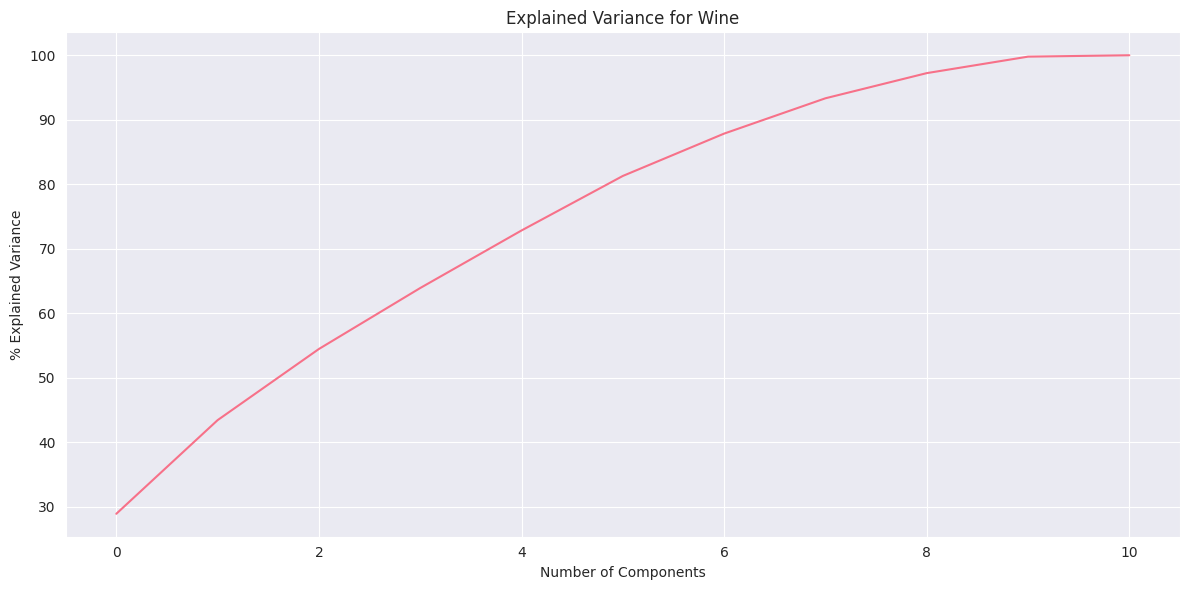

In [6]:
evaluate_pca(wine_white_df)

https://scribe.rip/@sanchitamangale12/scree-plot-733ed72c8608

If we should keep at least 80% of the total variance in the original dataset. Then it seems good to try 4-6 for the white wine.


In [7]:
# Try to look for best n_neighbors using cross validation
train_evaluation(wine_white_df, 'quality', use_model="KNeighborsClassifier")

No 'n_neighbors' set. Looking for best value...
Optimal number of neighbors: 39


39

In [8]:
# A KNN model with 37 neighbors might rarely predict the minority classes (3, 8 and 9) correctly.
# Also, very weird when the number of samples are so low... Cannot use 37...

In [9]:
def brute_force_check_KNeighborsClassifier():
    df_acc = pd.DataFrame(columns=['PCA','n_neighbors','Resample','Accuracy'])
    
    for i in [False] + list(range(4, 7)):
        for j in list(range(1, 9, 2)) + list(range(37 - 4, 37 + 4 + 1, 2)):
            for k in [False, "undersample", "oversample", "smote"]:
                cur_accuracy = train_evaluation(
                    wine_white_df, 'quality', use_model="KNeighborsClassifier", 
                    use_pca_n_components=i,
                    use_resampler=k, class_knn_n_neighbors=j,
                    silent=True)
                print(f"Checked: PCA {i}, n_neighbors {j}, resample {k} -> {cur_accuracy}%")
                
                df_acc.loc[len(df_acc.index)] = [i, j, k, cur_accuracy]

    display(df_acc.sort_values(by='Accuracy', ascending=False))
    
brute_force_check_KNeighborsClassifier()

Checked: PCA False, n_neighbors 1, resample False -> 0.5132408575031526%
Checked: PCA False, n_neighbors 1, resample undersample -> 0.22698612862547288%
Checked: PCA False, n_neighbors 1, resample oversample -> 0.4968474148802018%
Cannot use SMOTE on dataset! Got error: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6
Checked: PCA False, n_neighbors 1, resample smote -> 0%
Checked: PCA False, n_neighbors 3, resample False -> 0.47162673392181587%
Checked: PCA False, n_neighbors 3, resample undersample -> 0.21059268600252207%
Checked: PCA False, n_neighbors 3, resample oversample -> 0.43883984867591425%
Cannot use SMOTE on dataset! Got error: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6
Checked: PCA False, n_neighbors 3, resample smote -> 0%
Checked: PCA False, n_neighbors 5, resample False -> 0.48675914249684743%
Checked: PCA False, n_neighbors 5, resample undersample -> 0.21185372005044137%
Checked: PCA False, n_neighbors 5, resample over

,PCA,n_neighbors,Resample,Accuracy
28,0,39,False,0.554855
16,0,33,False,0.554855
32,0,41,False,0.553594
20,0,35,False,0.552333
132,6,37,False,0.548550
...,...,...,...,...
79,5,3,smote,0.000000
75,5,1,smote,0.000000
71,4,41,smote,0.000000
69,4,41,undersample,0.000000


In [10]:
# Inspect #1 result with 56%

n_neighbors=31
Accuracy: 55.49%


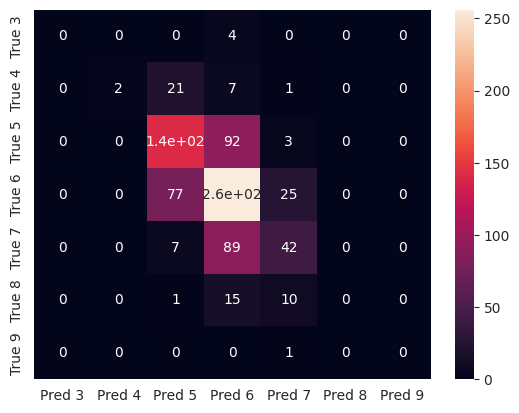




n_neighbors=33
Accuracy: 55.49%


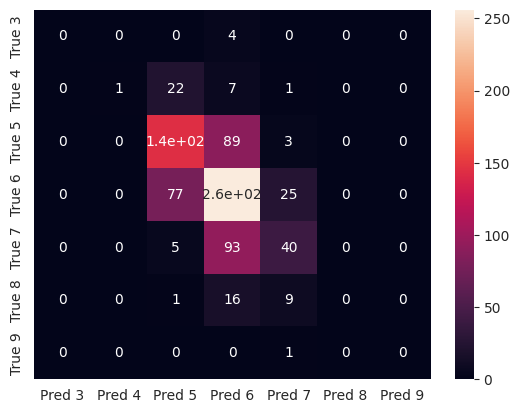




n_neighbors=35
Accuracy: 55.23%


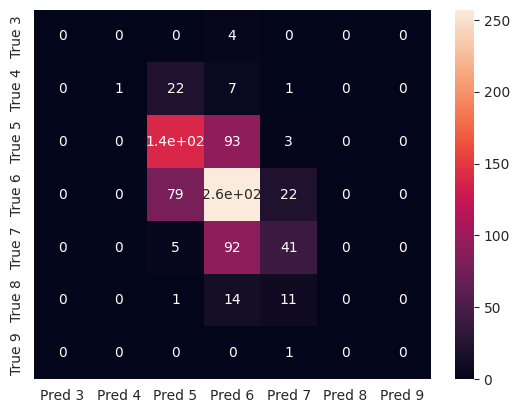

In [11]:
for i in range(31, 36, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_white_df, 'quality', use_model="KNeighborsClassifier", 
        use_pca_n_components=False,
        use_resampler=False, 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")

In [12]:
# Adjusting categories
# It is probably not allowed, but as there are so few high or low ranking wines, 
# it may be difficult to train a model on this data. If the categories are adjusted to: 
# low, medium and high quality wines (just 3 categories), the model might perform better. 
# There are a lot of wines in the 5-6 range. So the categories can be:
# - Low: 0-5
# - Medium: 5-6
# - High: 6-10

In [13]:
# Try to look for best n_neighbors using cross validation
train_evaluation(
    wine_white_df, 'quality', use_model="KNeighborsClassifier",
    classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']))

No 'n_neighbors' set. Looking for best value...
Optimal number of neighbors: 41


41

In [14]:
def brute_force_check_KNeighborsClassifier_adjust():
    df_acc = pd.DataFrame(columns=['PCA','n_neighbors','Resample','Accuracy'])
    
    for i in [False] + list(range(4, 7)):
        for j in list(range(1, 9 + 1, 2)) + list(range(53 - 4, 53 + 4 + 1, 2)):
            for k in [False, "undersample", "oversample", "smote"]:
                cur_accuracy = train_evaluation(
                    wine_white_df, 'quality', use_model="KNeighborsClassifier", 
                    classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']),
                    use_pca_n_components=i,
                    use_resampler=k, class_knn_n_neighbors=j,
                    silent=True)
                print(f"Checked: PCA {i}, n_neighbors {j}, resample {k} -> {cur_accuracy}%")
                
                df_acc.loc[len(df_acc.index)] = [i, j, k, cur_accuracy]

    display(df_acc.sort_values(by='Accuracy', ascending=False))
    
brute_force_check_KNeighborsClassifier_adjust()

Checked: PCA False, n_neighbors 1, resample False -> 0.5699873896595208%
Checked: PCA False, n_neighbors 1, resample undersample -> 0.5069356872635561%
Checked: PCA False, n_neighbors 1, resample oversample -> 0.562421185372005%
Checked: PCA False, n_neighbors 1, resample smote -> 0.5662042875157629%
Checked: PCA False, n_neighbors 3, resample False -> 0.5372005044136192%
Checked: PCA False, n_neighbors 3, resample undersample -> 0.5006305170239597%
Checked: PCA False, n_neighbors 3, resample oversample -> 0.5233291298865069%
Checked: PCA False, n_neighbors 3, resample smote -> 0.5258511979823455%
Checked: PCA False, n_neighbors 5, resample False -> 0.5296343001261034%
Checked: PCA False, n_neighbors 5, resample undersample -> 0.5094577553593947%
Checked: PCA False, n_neighbors 5, resample oversample -> 0.49936948297604034%
Checked: PCA False, n_neighbors 5, resample smote -> 0.5132408575031526%
Checked: PCA False, n_neighbors 7, resample False -> 0.5649432534678437%
Checked: PCA False

,PCA,n_neighbors,Resample,Accuracy
24,0,51,False,0.621690
28,0,53,False,0.616646
20,0,49,False,0.616646
36,0,57,False,0.615385
32,0,55,False,0.614124
...,...,...,...,...
46,4,3,oversample,0.480454
54,4,7,oversample,0.480454
49,4,5,undersample,0.472888
50,4,5,oversample,0.471627


In [15]:
# Inspect #1 result with 62%

n_neighbors=53
Accuracy: 61.66%


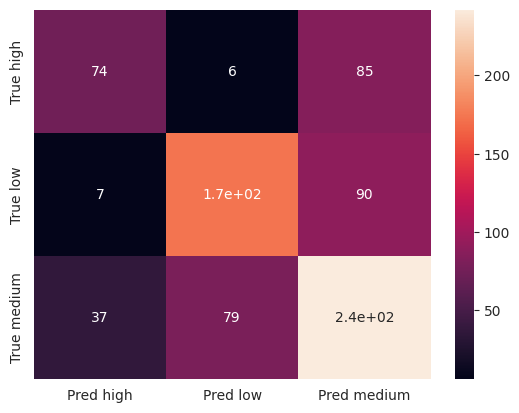




n_neighbors=55
Accuracy: 61.41%


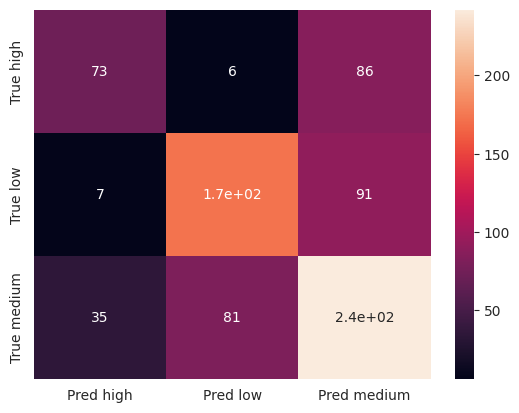




n_neighbors=57
Accuracy: 61.54%


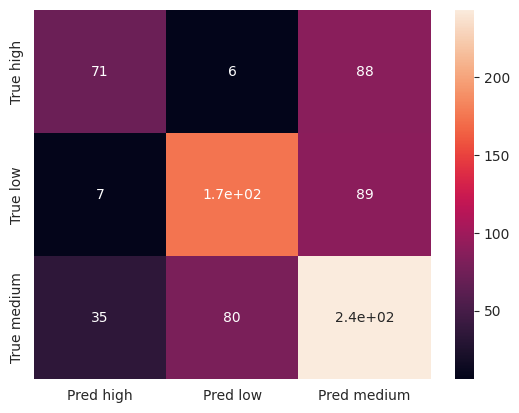

In [16]:
for i in range(53, 58, 2):
    print(f"n_neighbors={i}")
    accuracy, df_cm = train_evaluation(
        wine_white_df, 'quality', use_model="KNeighborsClassifier", 
        classifier_adjust_categories=((0, 5, 6, 10), ['low', 'medium', 'high']),
        use_pca_n_components=False,
        use_resampler=False, 
        class_knn_n_neighbors=i)
    plt.figure()
    cm = sns.heatmap(df_cm, annot=True)
    cm.get_figure()
    plt.show()
    print("\n\n")